In [23]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import logging
from typing import Optional, Dict, List

# Setting up logging to track execution details and errors 
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


class CollegeDataScraper:
    #Class to scrape and process college enrollment statistics.
    
    def __init__(self):
        #Initializing the scraper with URL and empty cache.
        self.url = "https://educationdata.org/college-enrollment-statistics"
        self.tables_cache = {}  #cache to store scraped tables 
        self._soup = None

    def _get_soup(self):
        """
        Getting BeautifulSoup object for the page with caching.
        
        Returns:
            BeautifulSoup object if successful, None otherwise
        """
        #fetching and parsing webpage if the soup object isn't already cashed 
        if self._soup is None:
            try:
                response = requests.get(self.url) #sending a get request to fetch the webpage
                response.raise_for_status() #raising an error for a bad resopnse (for example 404 error)
                self._soup = BeautifulSoup(response.content, 'html.parser') #using beautifulsoup to parse thorugh HTML content
                logger.info(f"Successfully retrieved page: status code {response.status_code}")
                return self._soup
            except requests.RequestException as e: #logging an error and returning Nona if there is an error while fetching the data
                logger.error(f"Failed to retrieve page: {str(e)}")
                return None
        return self._soup

    def scrap_table(self, table_index):
        """
        Scrape a specific table with error handling and caching.
        
        Args:
            table_index: Index of the table to scrape
            
        Returns:
            pandas DataFrame if successful, None otherwise
        """
        #checking if the table has been already scraped and cashed 
        if table_index in self.tables_cache:
            return self.tables_cache[table_index] #returning the cashed table if it's available

        soup = self._get_soup()
        if not soup:
            return None

        #finding all tables with the class 'tabl-responsive-mobile'
        tables = soup.find_all('table', {'class': 'table-responsive-mobile'})

        if not tables: #making sure the table is valid 
            logger.error("No tables found on the page.")
            return None #returning None if no table are found on the page

        if table_index >= len(tables):
            logger.error(f"Table index {table_index} is out of range. Only {len(tables)} tables found.")
            return None

        try:
            table = tables[table_index]
            headers = [th.text.strip() for th in table.find_all('th')]

            rows = []
            for row in table.find_all('tr')[1:]:  # Skip header row
                cells = [cell.text.strip() for cell in row.find_all('td')]
                if len(cells) == len(headers):
                    rows.append(cells)
                else:
                    logger.warning(f"Skipping malformed row in table {table_index}: {cells}")

            df = pd.DataFrame(rows, columns=headers)
            self.tables_cache[table_index] = df
            logger.info(f"Successfully scraped table {table_index} with shape {df.shape}")
            return df

        except Exception as e: #logging any errors that occur while processing
            logger.error(f"Error processing table {table_index}: {str(e)}")
            return None

    def clean_percentage_columns(self, df):
        """
        Clean percentage columns in the dataframe.
        
        Args:
            df: pandas DataFrame to clean
            
        Returns:
            pandas DataFrame with cleaned percentage values
        """
        df = df.copy() #making a copy to avoid modifying the original df 
        for col in df.columns: #checking if the column has percentage values and cleaning/converting it
            try:
                if '%' in col or df[col].str.contains('%').any():
                    df[col] = df[col].str.replace('%', '', regex=False).astype(float)
            except Exception as e: #logging warning if any columns fail to clean
                logger.warning(f"Skipping non-percentage column {col}: {str(e)}")
        return df

    def get_merged_data(self):
        """
        Get merged and cleaned enrollment data.
        
        Returns:
            pandas DataFrame if successful, None otherwise
        """
        df3 = self.scrap_table(3)  # Female enrollment
        df2 = self.scrap_table(2)  # Minority enrollment
        
        #checking if both tables were successfully scraped
        if df2 is None or df3 is None:
            logger.error("Cannot merge: one or both tables are missing.")
            return None
            
        try:
            merged_df = pd.merge(df3, df2, on='Year', how='inner')
            merged_df = self.clean_percentage_columns(merged_df)
            logger.info(f"Successfully merged data with shape {merged_df.shape}")
            return merged_df
        except Exception as e:
            logger.error(f"Error merging data: {str(e)}")
            return None

INFO:__main__:Successfully retrieved page: status code 200
INFO:__main__:Successfully scraped table 3 with shape (14, 3)
INFO:__main__:Successfully scraped table 2 with shape (14, 3)
INFO:__main__:Successfully merged data with shape (14, 5)
/var/folders/_7/mhd9w0zj49b4_rpd43hsdnh00000gn/T/ipykernel_44857/3985656069.py:28: RuntimeWarning: overflow encountered in square
  cost = np.mean((y_pred - y) ** 2)
/var/folders/_7/mhd9w0zj49b4_rpd43hsdnh00000gn/T/ipykernel_44857/3985656069.py:27: RuntimeWarning: invalid value encountered in subtract
  self.theta -= self.learning_rate * gradients



Analysis Results: {'r2_score': nan, 'coefficients': {'bias': nan, 'coefficients': array([nan])}, 'feature_importance': {'% Racial or Ethnic Minority Enrollment': nan}, 'model': <__main__.ManualLinearRegression object at 0x13f352ad0>}


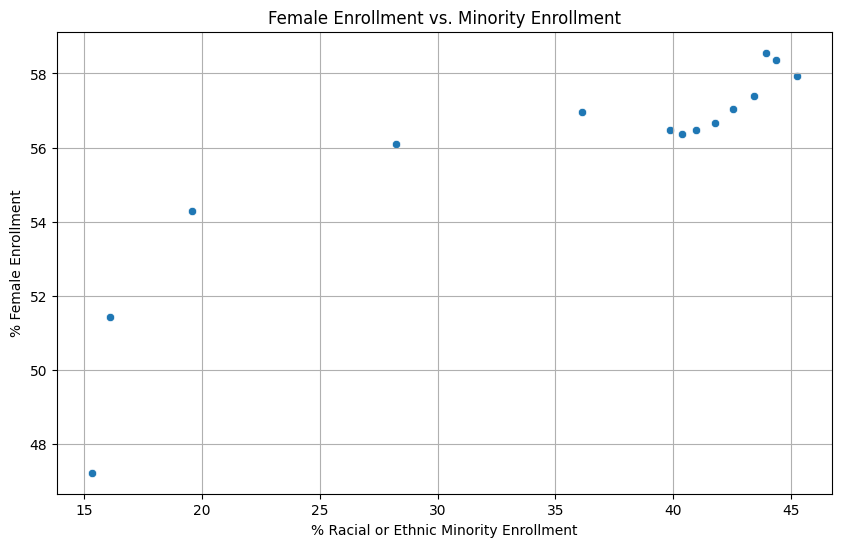

In [24]:
class ManualLinearRegression:
    #initializing the model parameteres
    def __init__(self, learning_rate=0.01, iterations=1000):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.theta = None
        self.cost_history = []

    def add_ones(self, X):
        #Adding a column of ones to the input features for the bias term.
        return np.c_[np.ones(X.shape[0]), X]

    def fit(self, X, y):
        #fitting the lienar regression model using gradient descent
        X_b = self.add_ones(X)
        n_samples, n_features = X_b.shape
        self.theta = np.random.randn(n_features)
        
        for _ in range(self.iterations):
            y_pred = X_b.dot(self.theta)
            gradients = (2 / n_samples) * X_b.T.dot(y_pred - y)
            self.theta -= self.learning_rate * gradients
            cost = np.mean((y_pred - y) ** 2)
            self.cost_history.append(cost)

    def predict(self, X):
        #Predicitng using the trained model 
        X_b = self.add_ones(X)
        return X_b.dot(self.theta)

    def score(self, X, y):
        #Calcualting  R² score of the model
        y_pred = self.predict(X)
        ss_total = np.sum((y - np.mean(y)) ** 2)
        ss_residual = np.sum((y - y_pred) ** 2)
        return 1 - (ss_residual / ss_total)

    def get_coefficients(self):
        #Returning the model coefficients and bias term.
        return {
            'bias': self.theta[0],
            'coefficients': self.theta[1:]
        }

def analyze_enrollment_trends(df, feature_cols, target_col):
    """
    Analyze enrollment trends using manual linear regression.
    
    Args:
        df: DataFrame containing the data
        feature_cols: List of feature column names
        target_col: Name of the target column
        
    Returns:
        Dictionary containing analysis results
    """
    X = df[feature_cols].values
    y = df[target_col].values

    #Creating and training the model 
    model = ManualLinearRegression(learning_rate=0.01, iterations=1000)
    model.fit(X, y)

    #calculating model perfoamnce and coefficients
    r2_score = model.score(X, y)
    coefficients = model.get_coefficients()
    
    #returnign analysis results
    return {
        'r2_score': r2_score,
        'coefficients': coefficients,
        'feature_importance': dict(zip(feature_cols, coefficients['coefficients'])),
        'model': model
    }

#main execution block 
if __name__ == "__main__":
    scraper = CollegeDataScraper()
    merged_df = scraper.get_merged_data()
    
    if merged_df is not None:
        # Female and minority enrollment analysis
        feature_cols = ['% Racial or Ethnic Minority Enrollment']
        target_col = '% Female Enrollment'
        results = analyze_enrollment_trends(merged_df, feature_cols, target_col)
        print("\nAnalysis Results:", results)
        
        #creating visualizations - scatter plot
        plt.figure(figsize=(10, 6))
        sns.scatterplot(
            data=merged_df,
            x=feature_cols[0],
            y=target_col
        )
        plt.title('Female Enrollment vs. Minority Enrollment')
        plt.xlabel('% Racial or Ethnic Minority Enrollment')
        plt.ylabel('% Female Enrollment')
        plt.grid(True)
        plt.show()